> **Algoritmos para Big Data**

> **Filipe Silva**

> **Fernando Piedade**

> **2023/24**


# Introduction

This project aims to consolidate practical knowledge in the design and implementation of a computational solution to respond to a large-scale data analysis problem.

In terms of implementation tools, the project must essentially use features provided by the Apache Spark platform and the Python programming language.


## Structured streaming

A key aspect of structured streaming is to acquire/send data from a streaming data producer/consumer. That is, from a streaming source/sink.

Apache Spark provides methods to read/write from/to a stream,
accordingly to some formats we may select from. Of course, some kind of configuration is required.

Firstly, there are the usual file-based formats like json, parquet, csv, text, and so on.
Also, we can use socket connections to get/send text data from/to TCP servers, and more importantly, we can rely on functionalities of advanced message systems like Apache Kafka, which will play a sort of buffering role.

Secondly, we have to set an output mode, which defines how the results will be delivered. For instance, to see all data every time, only updates, or just the new records.

Further details can be found in https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html


# Problem formulation

This exercise is about detecting credit card frauds in near real-time. This case-study is based on a Kaggle dataset that it is available in https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions. The dataset is expected to be a realistic example of synthetic data regarding credit card transactions.

We assume that a ML classification model has already been created and made available. Therefore, now we have to deal with a stream of transactions that are expected to be processed, like it would be in in a real-time scenario. Hence, we will simulate such scenario, mostly relying on Spark's Structured Streaming.

The functional requirements for the Spark program we are going to create are as follows:

1. To load a ML model previously built.
2. To process credit card transactions held in a simulated data stream, by applying the ML model.
3. To explore the results obtained.

Also, in order to speed up some processing, we will use some files that were computed in advance.

**Data available**

- The dataset about the stream of credit card transactions can be downloaded from the location

> https://bigdata.iscte.me/abd/credit-card-transactions-stream.zip

- The ML classification model already built can be downloaded from the location

> https://bigdata.iscte.me/abd/model-LinearSVM-credit-cards.zip

All the files are in parquet format.


# Initial settings


## Additional packages and imports


In [1]:
import findspark, pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
import os, sys 
import time

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Create the Spark session

findspark.init()
findspark.find()

spark = SparkSession\
        .builder\
        .appName("StreamingCreditCards")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/25 10:08:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
# Some Spark related imports we will use hereafter

from pyspark.ml import PipelineModel


In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

## Useful functions


In [7]:
def plotBarColoured(df, xcol, ycol, colour): 
    return sns.barplot(data=df, x=xcol, y=ycol, color=colour)

# Collect and label data


In [8]:
# ! pwd & ls -la


In [ ]:
pwd

In [12]:
data_dir = '/Users/fernandopiedade/big-data/abd-final-project'

In [ ]:
ls -la $data_dir

## Reading the dataset


In [14]:
# Reading data

file_path = data_dir + 'credit-card-transactions-stream'
df_transactions = spark.read.parquet(file_path)


## Checking data

Schema, show and count.


In [15]:

df_transactions.printSchema()
df_transactions.show(5, truncate=False)
num_transactions = df_transactions.count()

num_transactions



root
 |-- User: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Use Chip: string (nullable = true)
 |-- Merchant Name: long (nullable = true)
 |-- Merchant City: string (nullable = true)
 |-- Merchant State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- MCC: integer (nullable = true)
 |-- Is Fraud?: string (nullable = true)
 |-- Correct Amount: float (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Min: integer (nullable = true)
 |-- Transaction_Id: long (nullable = true)



+----+----+----+-----+---+-------------------+-----------------+-------------------+-------------+--------------+-------+----+---------+--------------+----+---+--------------+
|User|Card|Year|Month|Day|Time               |Use Chip         |Merchant Name      |Merchant City|Merchant State|Zip    |MCC |Is Fraud?|Correct Amount|Hour|Min|Transaction_Id|
+----+----+----+-----+---+-------------------+-----------------+-------------------+-------------+--------------+-------+----+---------+--------------+----+---+--------------+
|0   |0   |2002|9    |1  |2023-05-02 06:21:00|Swipe Transaction|3527213246127876953|La Verne     |CA            |91750.0|5300|No       |134.09        |6   |21 |0             |
|0   |0   |2002|9    |1  |2023-05-02 06:42:00|Swipe Transaction|-727612092139916043|Monterey Park|CA            |91754.0|5411|No       |38.48         |6   |42 |1             |
|0   |0   |2002|9    |2  |2023-05-02 06:22:00|Swipe Transaction|-727612092139916043|Monterey Park|CA            |91754.0

24386900

# Explore and evaluate data

At this point, we assume that data has been properly checked while model was created.

We leave it now but proper checking is warranted. Just do a plot of transactions over time.


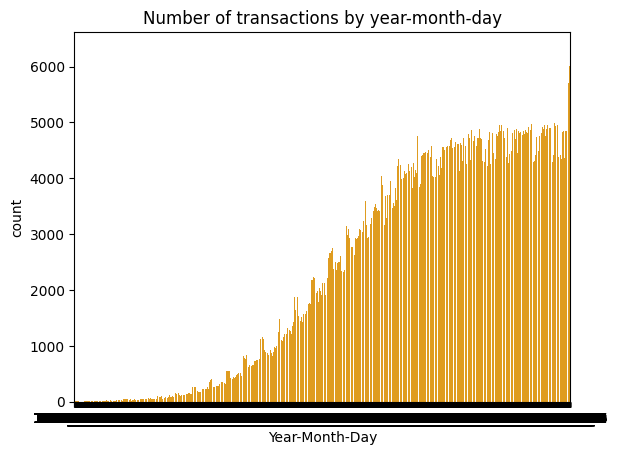

In [16]:
# Just to remember ... number of transactions by year-month-day

df_plot = ( df_transactions
            .groupby(['Year', 'Month', 'Day'])
            .count()
            .withColumn('Year-Month-Day', F.concat('Year',F.lit('_'),'Month',F.lit('_'),'Day'))
            .sort('Year-Month-Day', ascending=True)
            .toPandas()
          )
plotBarColoured(df_plot, 'Year-Month-Day', 'count', 'orange')
plt.title('Number of transactions by year-month-day')
plt.show()


In [17]:
df_plot.head()

,Year,Month,Day,count,Year-Month-Day
0,1991,10,1,6,1991_10_1
1,1991,10,10,4,1991_10_10
2,1991,10,11,1,1991_10_11
3,1991,10,12,3,1991_10_12
4,1991,10,13,8,1991_10_13


# Data Stream


In [18]:
rate_source = spark.readStream.format("rate").load()

In [19]:
rate_source.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- value: long (nullable = true)



In [20]:
# We should guarantee that we are using data sorted by transaction id (aka time)

df_transactions = df_transactions.sort('Transaction_ID')

In [21]:
df_transactions.select('Year', 'Month', 'Day', 'Time', 'Hour', 'Min', 'Transaction_ID').show(20,truncate=False)

+----+-----+---+-------------------+----+---+--------------+
|Year|Month|Day|Time               |Hour|Min|Transaction_ID|
+----+-----+---+-------------------+----+---+--------------+
|2002|9    |1  |2023-05-02 06:21:00|6   |21 |0             |
|2002|9    |1  |2023-05-02 06:42:00|6   |42 |1             |
|2002|9    |2  |2023-05-02 06:22:00|6   |22 |2             |
|2002|9    |2  |2023-05-02 17:45:00|17  |45 |3             |
|2002|9    |3  |2023-05-02 06:23:00|6   |23 |4             |
|2002|9    |3  |2023-05-02 13:53:00|13  |53 |5             |
|2002|9    |4  |2023-05-02 05:51:00|5   |51 |6             |
|2002|9    |4  |2023-05-02 06:09:00|6   |9  |7             |
|2002|9    |5  |2023-05-02 06:14:00|6   |14 |8             |
|2002|9    |5  |2023-05-02 09:35:00|9   |35 |9             |
|2002|9    |5  |2023-05-02 20:18:00|20  |18 |10            |
|2002|9    |5  |2023-05-02 20:41:00|20  |41 |11            |
|2002|9    |6  |2023-05-02 06:16:00|6   |16 |12            |
|2002|9    |7  |2023-05-

## Creating a continuous data stream

Circularly replaying the data as long as the process is running. It will be a simulated streaming version of the data.


In [22]:
# Circularly replay the data

data_stream = ( rate_source
                   .select(F.expr(f'value % {num_transactions}').alias('Transaction_Id'), 'timestamp')
                   .join(df_transactions, 'Transaction_Id')
              )

In [23]:
data_stream.printSchema()

root
 |-- Transaction_Id: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- User: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Use Chip: string (nullable = true)
 |-- Merchant Name: long (nullable = true)
 |-- Merchant City: string (nullable = true)
 |-- Merchant State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- MCC: integer (nullable = true)
 |-- Is Fraud?: string (nullable = true)
 |-- Correct Amount: float (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Min: integer (nullable = true)



In [25]:
cols_to_check = data_stream.columns

# Model deployment


# Loading the binary classification model


In [26]:
# Read the ML model via pipeline api (not the simple pipeline)

persisted_model = PipelineModel.load(data_dir+'model-LinearSVM-credit-cards')

In [27]:
# Check the model, namely the stages that were used

persisted_model.stages

[StringIndexerModel: uid=StringIndexer_e1064637f5a0, handleInvalid=skip, numInputCols=2, numOutputCols=2,
 OneHotEncoderModel: uid=OneHotEncoder_6a398697f374, dropLast=true, handleInvalid=error, numInputCols=2, numOutputCols=2,
 VectorAssembler_f41b5139a541,
 LinearSVCModel: uid=LinearSVC_912312635f03, numClasses=2, numFeatures=11838]

## Streaming data transformer

Let us set the operation to be applied to the stream.


In [29]:
# ML model directly applied to the streaming dataframe using `transform`

prediction_stream = persisted_model.transform(data_stream)


In [30]:
prediction_stream.printSchema()

root
 |-- Transaction_Id: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- User: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Use Chip: string (nullable = true)
 |-- Merchant Name: long (nullable = true)
 |-- Merchant City: string (nullable = true)
 |-- Merchant State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- MCC: integer (nullable = true)
 |-- Is Fraud?: string (nullable = true)
 |-- Correct Amount: float (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Min: integer (nullable = true)
 |-- Use Chip Index: double (nullable = false)
 |-- Merchant City Index: double (nullable = false)
 |-- Use Chip OHE: vector (nullable = true)
 |-- Merchant City OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |

## Consuming predictions


The final step is to do something with the prediction data.
For the time being, we are going to limit this step to just querying the data.

For real-world application, we can offer this kind of service to other applications.

Maybe in the form of an HTTP-based API or through pub/sub messaging interactions.


In [31]:
cols_to_check.append('prediction')
cols_to_check

['Transaction_Id',
 'timestamp',
 'User',
 'Card',
 'Year',
 'Month',
 'Day',
 'Time',
 'Use Chip',
 'Merchant Name',
 'Merchant City',
 'Merchant State',
 'Zip',
 'MCC',
 'Is Fraud?',
 'Correct Amount',
 'Hour',
 'Min',
 'prediction']

In [32]:
# Just in case we want to start a table containing results but from scratch

spark.sql("drop table if exists cardtransactionstable")

DataFrame[]

In [33]:
# In case we want to store in an in-memory table (the sink). 
# The query name will be the table name

# After executing the code, the streaming computation will start in the background

query_1 = ( prediction_stream
                        .select(cols_to_check)
                        .writeStream
                        .queryName("cardtransactionstable")
                        .outputMode("append")  # append, update
                        .format("memory")
                        .start()
                   )


24/04/11 20:39:32 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /private/var/folders/cw/wl2n47pd62b20l16hsnf0h1c0000gn/T/temporary-3d209751-031d-4f75-b465-1a5bf18d180a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/04/11 20:39:32 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [30]:
# Setup an aggregation by day concerning the number of frauds detected
#
# We leave this as exercise

# fraud_count = ...

# query_2 = ...

In [34]:
# Some extra checks

spark.streams.active[0].isActive


True

In [35]:
query_1.status


{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

24/04/11 20:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1498.0 KiB


In [36]:
query_1.lastProgress


# Exploring results


In [37]:
# Figure out the tables we hold

spark.sql("show tables").show(truncate=False)


+---------+---------------------+-----------+
|namespace|tableName            |isTemporary|
+---------+---------------------+-----------+
|         |cardtransactionstable|true       |
+---------+---------------------+-----------+



In [41]:
# Interactively query in-memory table

spark.sql("select * from cardtransactionstable").show(truncate=False)  


+--------------+-----------------------+----+----+----+-----+---+-------------------+------------------+--------------------+-------------+--------------+-------+----+---------+--------------+----+---+----------+
|Transaction_Id|timestamp              |User|Card|Year|Month|Day|Time               |Use Chip          |Merchant Name       |Merchant City|Merchant State|Zip    |MCC |Is Fraud?|Correct Amount|Hour|Min|prediction|
+--------------+-----------------------+----+----+----+-----+---+-------------------+------------------+--------------------+-------------+--------------+-------+----+---------+--------------+----+---+----------+
|16            |2024-04-11 20:39:48.401|0   |0   |2002|9    |8  |2023-05-02 06:10:00|Swipe Transaction |-34551508091458520  |La Verne     |CA            |91750.0|5912|No       |147.45        |6   |10 |0.0       |
|0             |2024-04-11 20:39:32.401|0   |0   |2002|9    |1  |2023-05-02 06:21:00|Swipe Transaction |3527213246127876953 |La Verne     |CA       

24/04/11 20:40:25 WARN DAGScheduler: Broadcasting large task binary with size 1498.6 KiB


In [ ]:
# Interactively another query in-memory table

spark.sql("select count(*) from cardtransactionstable").show()

+--------+
|count(1)|
+--------+
|      17|
+--------+



## Stopping the process


In [43]:
# We can turn off the query now and eventually set up a different one

query_1.stop()

24/04/11 20:40:38 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 3, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@51bfef7f] is aborting.
24/04/11 20:40:38 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 3, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@51bfef7f] aborted.


24/04/11 20:40:38 WARN TaskSetManager: Lost task 1.0 in stage 45.0 (TID 128) (10.192.11.24 executor driver): TaskKilled (Stage cancelled: Job 33 cancelled part of cancelled job group 52d5ebed-088d-40e7-b7d3-3390f80ea61c)
24/04/11 20:40:38 WARN TaskSetManager: Lost task 5.0 in stage 45.0 (TID 132) (10.192.11.24 executor driver): TaskKilled (Stage cancelled: Job 33 cancelled part of cancelled job group 52d5ebed-088d-40e7-b7d3-3390f80ea61c)
24/04/11 20:40:38 WARN TaskSetManager: Lost task 7.0 in stage 45.0 (TID 134) (10.192.11.24 executor driver): TaskKilled (Stage cancelled: Job 33 cancelled part of cancelled job group 52d5ebed-088d-40e7-b7d3-3390f80ea61c)
24/04/11 20:40:38 WARN TaskSetManager: Lost task 4.0 in stage 45.0 (TID 131) (10.192.11.24 executor driver): TaskKilled (Stage cancelled: Job 33 cancelled part of cancelled job group 52d5ebed-088d-40e7-b7d3-3390f80ea61c)
24/04/11 20:40:38 WARN TaskSetManager: Lost task 0.0 in stage 45.0 (TID 127) (10.192.11.24 executor driver): TaskKil

In [38]:
# Notice that in a production environment, we have to establish 
# that the query is awaiting termination so to prevent the driver 
# process from termination when the stream is ative

# query_1.awaitTermination()

# query_2.awaitTermination()


# Additional exercise

Once this exercise is completed, create a new notebook with similar implementation but using a different streaming setup. Specifically, relying also in the messaging system Apache Kafka.


# References


- Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
- Stream Processing with Apache Spark. G. Maas and F. Garillot. O'Reilly, 2019
